# Music Unmixing using MUSDB
## 1. Introduction to the sigsep ecosystem

![](https://sisec18.unmix.app/static/img/hero_header.4f28952.svg)



### Installation of Requirements (**colab only**)

Please use the conda environment or the Pipfile if you want to run this notebook outside of colab in your local environment.



In [ ]:
# update pandas since we don't support 0.24.x
# restart kernel after this update!
!pip install pandas==0.25.1

In [ ]:
!apt install -y libsndfile1 ffmpeg
!pip install norbert

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


### Generic Imports

In [ ]:
from IPython.display import Audio, display
import urllib.request
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.transforms import BlendedGenericTransform
import scikit_posthocs as sp
from urllib.request import urlopen
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## The MUSDB18 and MUSDB18HQ Dataset

The _musdb18_ is a dataset of 150 full lengths music tracks (~10h duration) of different styles along with their isolated _drums_, _bass_, _vocals_ and _others_ stems.

### References and info

* Website: https://sigsep.github.io/musdb/
* Download link:  [Download Full Dataset (4.4 Gb)](https://zenodo.org/record/1117372/accessrequest)
   
### Demo version
   7s Samples (140Mb) are included/will automatically be downloaded in this notebook.

### musdb comes in MP4 format

<img src="https://sigsep.github.io/assets/img/stems.a411b49d.png" align="right" width="190px">

All files from the _musdb18_ dataset are encoded in the [Native Instruments stems format](http://www.stems-music.com/) (.mp4). It is a multitrack format composed of 5 stereo streams, each one encoded in AAC @256kbps. These signals correspond to:

- `0` - The mixture,
- `1` - The drums,
- `2` - The bass,
- `3` - The rest of the accompaniment,
- `4` - The vocals.

we need a converter to load it.


### Introducing stempeg

[**stempeg**](https://github.com/faroit/stempeg) is a python package to read and write STEM files. Technically it is just wrapper for ffmpeg that makes it easier to handle multistream MP4 audio files.


Lets download a track and listen to it....


In [ ]:
urllib.request.urlretrieve(
    'https://raw.githubusercontent.com/faroit/stempeg/master/stempeg/data/The%20Easton%20Ellises%20-%20Falcon%2069.stem.mp4',
    'track.stem.mp4')

('track.stem.mp4', <http.client.HTTPMessage at 0x7f06bc1a7780>)

### Readinq a mp4 file
We use stempeg to read the file we just downloaded, and put the result in the `S` variable.

`S` is the stem tensor that includes the time domain signals scaled to `[-1..1]`. The shape is `(stems, samples, channels)`.

In [ ]:
import stempeg
S, rate = stempeg.read_stems('track.stem.mp4')
print(S.shape)

(5, 265216, 2)


### Playing some audio back

Now that we have obtained the audio array, let's play it back. `S[0]` is the mixture, `S[4]` is the vocals.

In [ ]:
print("Mixture")
display(Audio(S[0].T, rate=rate))
print("Vocals")
display(Audio(S[4].T, rate=rate))
print("Drums")
display(Audio(S[1].T, rate=rate))

Output hidden; open in https://colab.research.google.com to view.

## Load the MUSDB Dataset

Ok, we now understand stempeg. Let's download musdb.

In [ ]:
import musdb
mus = musdb.DB(download=True)

### Load a single Audio Track
From musdb, let's now play one single track, called `Moosmusic - Big Dummy Shake`.

In [ ]:
track = mus[42]
print(track.name)
Audio(track.audio.T, rate=track.rate)

James May - On The Line


#### Access Targets
Since it's a stem object, it comes not only with the mixture, but also with the sources.
Let's list the name of these sources.

A `Track` object comes with a property called `targets`, which is a dictionary of `Track` objects.

In [ ]:
track.targets

OrderedDict([('vocals', vocals),
             ('drums', drums),
             ('bass', bass),
             ('other', other),
             ('accompaniment', bass+drums+other),
             ('linear_mixture', vocals+bass+drums+other)])

Let's playback the `vocals` item:

In [ ]:
vocals = track.targets['vocals']
Audio(vocals.audio.T, rate=track.rate)

### Recap

We learned how to load musdb, access a track and play some target from it.

## Display Spectrograms

### Spectrograms

Spectrograms are _images_ that give the _energy_ of an audio signal along time and frequency.
It's a very useful representation for audio.

### Import `librosa`
We want to go further the analysis, and now we will be computing spectrograms on this song.

For this, let's import the `librosa` library.

In [ ]:
import librosa
import librosa.display

### Compute spectrograms
Let's use `librosa` to compute the mixture complex STFT, which we call `X`.

It's modulus is the spectrogram:

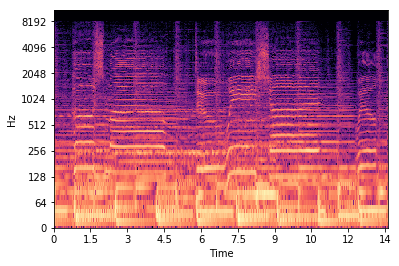

In [ ]:
X = librosa.stft(librosa.to_mono(track.audio.T))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(X), ref=np.max), y_axis='log', x_axis='time')


Compute the vocal and accompaniment Spectrogram

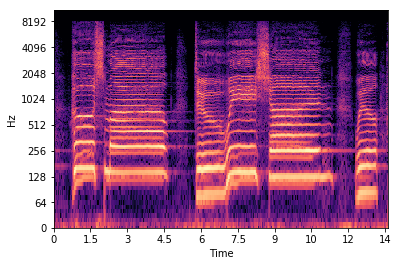

In [ ]:
S_vocals = np.abs(librosa.stft(librosa.to_mono(track.targets['vocals'].audio.T)))
librosa.display.specshow(librosa.amplitude_to_db(S_vocals, ref=np.max), y_axis='log', x_axis='time')


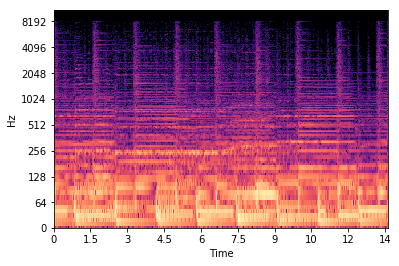

In [ ]:
S_accompaniment = np.abs(librosa.stft(librosa.to_mono(track.targets['accompaniment'].audio.T)))
librosa.display.specshow(librosa.amplitude_to_db(S_accompaniment, ref=np.max), y_axis='log', x_axis='time')


## Apply Ratio Mask Filtering (Oracle)

### Introduction: reconstruct audio !

Spectrograms are images ! We cannot reconstruct easily audio for them, because we miss the phase information.

However, if we have the spectrograms of all the sources, we may use the mixture and its phase to get good estimates for the sources.
That's what called `oracle filtering` in the jargon.

Let's separate the vocals this way.

In short, it means keeping only the parts of the mix that are vocals. This is done by applying a *mask* to the mix, which is either 1 (vocals) or 0 (non vocals.). This mask is given by:

$Mask_{vocals}=\frac{S_{vocals}}{S_{vocals}+S_{accompaniment}}$

and is called a *ratio mask*

### Compute the ratio mask

In [ ]:
# small epsilon to avoid dividing by zero
eps = np.finfo(np.float).eps

# compute model as the sum of spectrograms
model = eps + np.abs(S_vocals) + np.abs(S_accompaniment)

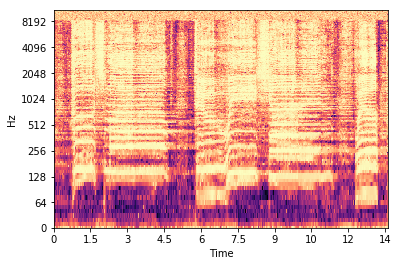

In [ ]:
# compute ratio mask as the ratio between source spectrogram and total
Mask_vocals = np.divide(np.abs(S_vocals), model)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(Mask_vocals), ref=np.max), y_axis='log', x_axis='time')

### Filter

So now, we simply apply the mask on the mixture STFT `X`, this gives us our estimate `Y_vocals`, with the phase. Let's go back in the time domain and play it.

In [ ]:
# multiply the mix by the mask
Y_vocals = np.multiply(X, Mask_vocals)

# invert to time domain
vocals_estimate = librosa.istft(Y_vocals)

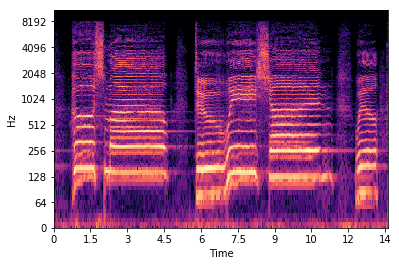

In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y_vocals), ref=np.max), y_axis='log', x_axis='time')
Audio(vocals_estimate, rate=track.rate)


Lets do the same for the accompaniment

In [ ]:
Mask_accompaniment = np.divide(np.abs(S_accompaniment), model)
Y_accompaniment = np.multiply(X, Mask_accompaniment)
accompaniment_estimate = librosa.istft(Y_accompaniment)

In [ ]:
Audio(accompaniment_estimate, rate=track.rate)


## Scale and Evaluate

OK, so we did our first separation!

Let's now:
1. go to stereo
2. apply all this on musdb tracks
3. evaluate the quality of the separation

### Stereo

`librosa` is nice, but its STFT does not handle stereo signals out-of-the-box.

Let's use the dedicated `stft` function from `scipy`

In [ ]:
from scipy.signal import stft, istft
f, t, X = stft(track.audio.T, nperseg=4096, noverlap=3072)
print(X.shape)
t, audio = istft(X, track.rate, nperseg=4096, noverlap=3072)


(2, 2049, 294)


The shape of this is now `(nb_channels, nb_features, nb_frames)`

### Generalize to all targets in MUSDB

Let's apply exactly the same procedure as before, but with items from musdb.

Let's start by processing the track we have loaded before.

In [ ]:
import torch
# small epsilon to avoid dividing by zero
eps = np.finfo(np.float).eps

# compute STFT of Mixture
N = track.audio.shape[0]  # remember number of samples for future use
X = stft(track.audio.T, nperseg=4096, noverlap=3072)[-1]
(I, F, T) = X.shape

# Compute sources spectrograms
P = {}
# compute model as the sum of spectrograms
model = eps

for name, source in track.sources.items():
    # compute spectrogram of target source:
    unmix = torch.hub.load('sigsep/open-unmix-pytorch', model='umx', target=name)
    P[name] = unmix(torch.tensor(track.audio.T[None, ...]).float()).detach().numpy()[:, 0, ...].transpose(1, 2, 0)
#     P[name] = np.abs(stft(source.audio.T, nperseg=4096, noverlap=3072)[-1])
    model += P[name]

# now performs separation
estimates = {}
for name, source in track.sources.items():
    # compute soft mask as the ratio between source spectrogram and total
    Mask = P[name] / model

    # multiply the mix by the mask
    Yj = Mask * X

    # invert to time domain
    target_estimate = istft(Yj, nperseg=4096, noverlap=3072)[1].T

    # set this as the source estimate
    estimates[name] = target_estimate

Using cache found in /root/.cache/torch/hub/sigsep_open-unmix-pytorch_master
Using cache found in /root/.cache/torch/hub/sigsep_open-unmix-pytorch_master
Using cache found in /root/.cache/torch/hub/sigsep_open-unmix-pytorch_master
Using cache found in /root/.cache/torch/hub/sigsep_open-unmix-pytorch_master


We separated the signals ! Let's play that

In [ ]:
for target, estimate in estimates.items():
  display(Audio(estimate.T, rate=track.rate))

Output hidden; open in https://colab.research.google.com to view.

### Evaluate using museval

Sounding pretty good, right ?

We may now evaluate separation through bsseval scores, obtained with the `museval` package

In [ ]:
import museval

track_scores = museval.eval_mus_track(track, estimates)
print(track_scores)

vocals          ==> SDR:   8.310  SIR:  10.591  ISR:  13.464  SAR:  11.004  
drums           ==> SDR:   6.793  SIR:   9.253  ISR:   9.555  SAR:   8.098  
bass            ==> SDR:   5.393  SIR:   5.373  ISR:   9.896  SAR:   8.575  
other           ==> SDR:   4.096  SIR:   7.660  ISR:   5.359  SAR:   5.740  



If you like, you may directly access the details of the results as a `panda` Dataframe

In [ ]:
track_scores.df

time  target metric     score                    track
0    0.0  vocals    SDR  11.26577  James May - On The Line
1    1.0  vocals    SDR  12.07745  James May - On The Line
2    2.0  vocals    SDR   9.61378  James May - On The Line
3    3.0  vocals    SDR   9.56470  James May - On The Line
4    4.0  vocals    SDR  11.50456  James May - On The Line
..   ...     ...    ...       ...                      ...
91   1.0   other    SIR   8.46797  James May - On The Line
92   2.0   other    SIR   9.90201  James May - On The Line
93   3.0   other    SIR   8.57905  James May - On The Line
94   4.0   other    SIR  13.99113  James May - On The Line
95   5.0   other    SIR  10.55585  James May - On The Line

[96 rows x 5 columns]

## Process/Iterate over MUSDB18

We have all the ingredients to apply this filtering to all items from musdb, and evaluate the overall quality for all tracks !

### List all tracks in musdb

Just through a for loop

In [ ]:
mus = musdb.DB(download=True, subsets='train')

for track in mus:
    print(track.name)

A Classic Education - NightOwl
ANiMAL - Clinic A
ANiMAL - Easy Tiger
ANiMAL - Rockshow
Actions - Devil's Words
Actions - One Minute Smile
Actions - South Of The Water
Aimee Norwich - Child
Alexander Ross - Goodbye Bolero
Alexander Ross - Velvet Curtain
Angela Thomas Wade - Milk Cow Blues
Atlantis Bound - It Was My Fault For Waiting
Auctioneer - Our Future Faces
AvaLuna - Waterduct
BigTroubles - Phantom
Bill Chudziak - Children Of No-one
Black Bloc - If You Want Success
Celestial Shore - Die For Us
Chris Durban - Celebrate
Clara Berry And Wooldog - Air Traffic
Clara Berry And Wooldog - Stella
Clara Berry And Wooldog - Waltz For My Victims
Cnoc An Tursa - Bannockburn
Creepoid - OldTree
Dark Ride - Burning Bridges
Dreamers Of The Ghetto - Heavy Love
Drumtracks - Ghost Bitch
Faces On Film - Waiting For Ga
Fergessen - Back From The Start
Fergessen - Nos Palpitants
Fergessen - The Wind
Flags - 54
Giselle - Moss
Grants - PunchDrunk
Helado Negro - Mitad Del Mundo
Hezekiah Jones - Borrowed Hear

# Evaluation and Comparison to SiSEC 2018

Evaluating a method is nice, but it's really important to compare to state of the art.


For this reason, we enabled the possibility to automatically download the results from sisec2018.

### Add our results to an evaluation DataFrame
Now, let's add the result we just obtained and append it to the SiSEC ones

In [ ]:
mymethod = museval.aggregate.EvalStore(frames_agg='median', tracks_agg='median')
mymethod.add_track(track_scores)
print(mymethod)

Aggrated Scores (median over frames, median over tracks)
vocals          ==> SDR:  10.440  SIR:  16.163  ISR:  13.876  SAR:  12.654  
drums           ==> SDR:   8.592  SIR:  13.028  ISR:  11.406  SAR:  11.419  
bass            ==> SDR:   8.225  SIR:  11.052  ISR:  10.670  SAR:  10.976  
other           ==> SDR:   7.162  SIR:   9.673  ISR:  10.587  SAR:   9.300  



### Add SiSEC2018 results from other participants

Open the url, and process the results with the function we designed just up there.

In [ ]:
# Open URL
methods = museval.aggregate.MethodStore()
methods.add_sisec18()
methods.add_evalstore(mymethod, name='Oracle')
print(methods.df)

Done!
         time  target  ...                                      track  method
0         0.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
1         1.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
2         2.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
3         3.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
4         4.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
...       ...     ...  ...                                        ...     ...
6019095   1.0   other  ...                    James May - On The Line  Oracle
6019096   2.0   other  ...                    James May - On The Line  Oracle
6019097   3.0   other  ...                    James May - On The Line  Oracle
6019098   4.0   other  ...                    James May - On The Line  Oracle
6019099   5.0   other  ...                    James May - On The Line  Oracle

[6019100 rows x 6 columns]


### Display scores

use some `seaborn` code to display the scores of the great FOOOOOO method.

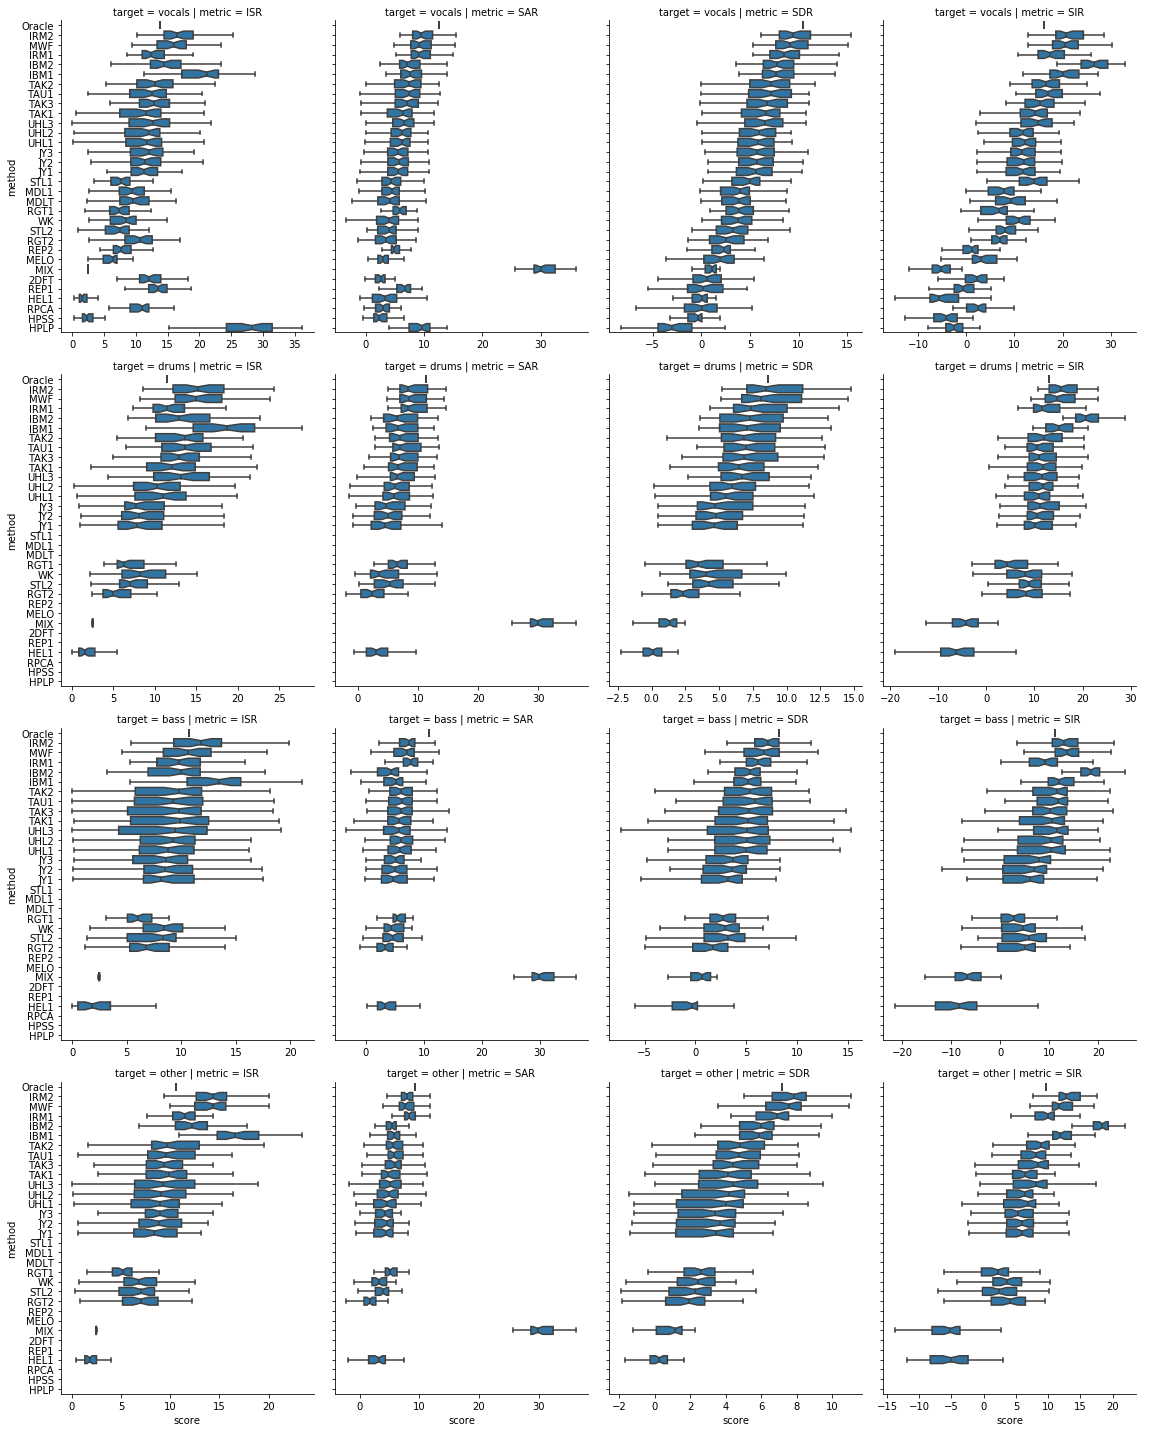

In [ ]:
# important!
df = methods.df.groupby(
    ['method', 'track', 'target', 'metric']
).median().reset_index()

# Get sorting keys (sorted by median of SDR:vocals)
df_sort_by = df[
    (df.metric == "SDR") &
    (df.target == "vocals")
]

# sort methods by score
methods_by_sdr = df_sort_by.score.groupby(
    df_sort_by.method
).median().sort_values().index.tolist()

g = sns.FacetGrid(
    df, row="target", col="metric",
    row_order=['vocals', 'drums', 'bass', 'other'],
    height=5, sharex=False, aspect=0.8
)
g = (g.map(
    sns.boxplot,
    "score",
    "method",
    orient='h',
    order=methods_by_sdr[::-1],
    showfliers=False,
    notch=True
).add_legend())

Maybe some significance plot will be more convincing for picky reviewers ?

Text(0.5, 1.0, 'vocals')

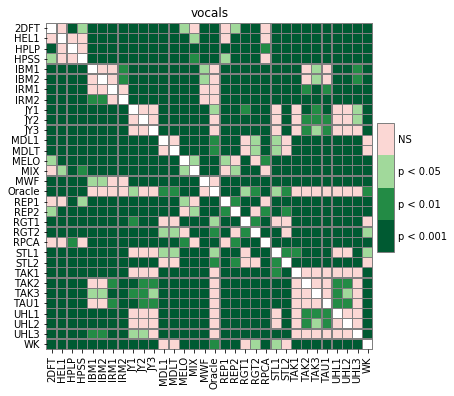

In [ ]:
# resort them by median SDR
# Get sorting keys (sorted by median of SDR:vocals score)

target = 'vocals'
df_voc = df[(df.target == target) & (df.metric == "SDR")].copy()

targets_by_voc_sdr = df_voc.score.groupby(
    df_voc.method
).median().sort_values().index.tolist()

# get the two sortings
df_voc['method'] = df_voc['method'].astype(pd.api.types.CategoricalDtype(categories=targets_by_voc_sdr, ordered=True))

# # prepare the pairwise plots
pc_voc = sp.posthoc_conover(df_voc, val_col='score', group_col='method', sort=True)

f_voc = plt.figure(figsize=(6, 6))
# Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.90, 0.35, 0.04, 0.3]}
ax, cb = sp.sign_plot(pc_voc, **heatmap_args)
ax.set_title(target)

Impressive. Let's publish this.